In [54]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [55]:
sent = np.load("en.1.npz")
T_proj = sent['projection_tensor']
source_langs = sent['source_languages']

In [56]:
T_proj[:,:,0].shape

(11, 12)

In [57]:
D = pd.DataFrame(T_proj[0])
M = T_proj[0] - T_proj[0].min()
M

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,
         1.,  1.,  1.,  0.,  0.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

de


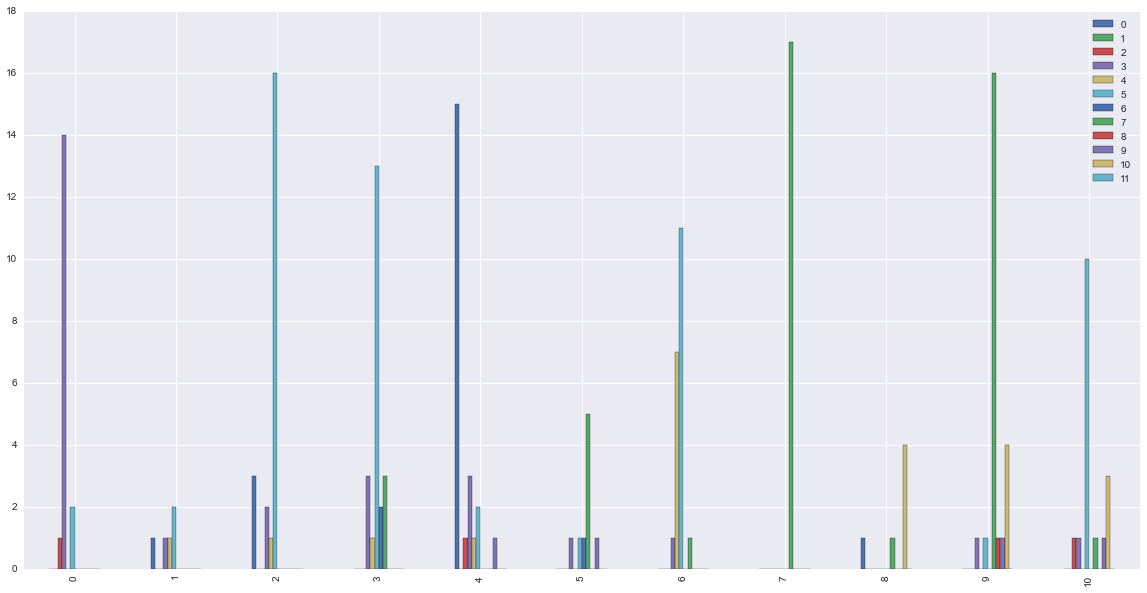

In [59]:
i = 4
print(source_langs[i])
M = T_proj[:,:,i]# - T_proj[:,:,i].min()

def softmax(matrix, temperature=1):
    m_exp = np.exp(matrix/temperature)
    return (m_exp.T / m_exp.sum(axis=1)).T

#for i in range(T_proj.shape[2]):
#    T_proj[:,:,i] = softmax(T_proj[:,:,i], 0.5)

#pd.DataFrame(softmax(M, 0.5)).plot(kind='bar', figsize=(20, 10))

# M -= M.min(axis=1)

#pd.DataFrame(M) *1

#for i in range(T_proj.shape[2]):
#    T_proj[:,:,i] = (T_proj[:,:,i].T * T_proj[:,:,i].sum(axis=1)).T

def sum_normalize(T_proj):
    return T_proj.sum(axis=2)

def row_normalize(M):
    return (M.T / M.sum(axis=1)).T

M_voted = sum_normalize(T_proj)

M_norm = sum_normalize(T_proj)
pd.DataFrame(M_voted).plot(kind='bar', figsize=(20, 10))
